In [1]:
import src as methods
import numpy as np
import pandas as pd

We intend to recommend a new restaurant for an individual to try based on a restuarant that they previously at (or similarily, a restuarant that they trust). This will be provided in the form of a link from Yelp's website that the user can provide.

In [2]:
query_restaurant = 'https://www.yelp.com/biz/buon-appetito-san-diego'

In [3]:
fp = 'data_ingestion.csv'
df = pd.read_csv(fp)

In [4]:
df.columns

Index(['Unnamed: 0', 'Name', 'URL', 'Phone', 'Latitude', 'Longitude',
       'Address', 'City', 'State', 'ZIP', 'Vertical', 'Rating', 'Review Count',
       'Yelp ID', 'Review1', 'Review2', 'Review3', 'Vertical1', 'Vertical2',
       'Vertical3', 'Reviews', 'polarity', 'subjectivity', 'Word1', 'Word2',
       'Word3', 'Word4', 'Word5'],
      dtype='object')

In [5]:
def data_to_A_1_matrix(df):
    
    # Helper Function 
    def idx_dictionary(iterable):
        dictionary = {}
        idx = 0
        for element in set(iterable): 
            dictionary[element] = idx
            idx += 1 
        return dictionary
    
    verticals = df.Vertical
    flattened = verticals.explode()
    
    # Explode all instances of the Vertical column
    unflattened = []
    for x in verticals:
        split = x.split(', ')
        unflattened.append(split)
        
    uniques = set(pd.Series(unflattened).explode().values)
    vert_dict = idx_dictionary(uniques)
    
    #Find update_tuples
    update_tuples = []
    for idx, verts in enumerate(unflattened):
        for v_instance in verts:
            if v_instance in vert_dict:
                update_tuples.append((idx, vert_dict[v_instance]))
                
    dim_i = df.shape[0]
    dim_j = len(vert_dict)
    y_labels = vert_dict.keys()
    x_labels = (df[['Yelp ID']].values).tolist()
    
    flattened_x_lab = [y for x in x_labels for y in x]
    
    return update_tuples, (dim_i, dim_j), list(y_labels), flattened_x_lab

In [6]:
A_tuples, dim, y_lab, x_lab = data_to_A_1_matrix(df)

In [7]:
y_lab[:10]

['Hot Dogs',
 'Beer Bar',
 'Sandwiches',
 'Vegan',
 'Coffee Roasteries',
 'Steakhouses',
 'Bars',
 'Food Trucks',
 'Japanese',
 'Beer']

In [8]:
x_lab[:10]

['AlO78to1upUkVhRx12XtVA',
 '7PGyWA51sSdw8M4fBXa9Gw',
 'n3sKOKoEk_gKhBvgfIwZaA',
 '4GT1sQ_pcKk4gBMrJddexw',
 'PzGU5brzhsVqumdU4qE5Rw',
 'aY_z6z6at7wyoW7sFhf4bA',
 '9z2faUubEPjEEpV1zyxH6g',
 'djfc2SAzd4xjn5HmUp8wow',
 'W0dzJ7E6R3kyAOXIlO_tbw',
 'Bne55NwL25KO_ntMgflb_A']

In [9]:
from tqdm import tqdm
from scipy.sparse import lil_matrix

In [10]:
# ---------------------------------------------------------------------
# A_matrix_func (WORKING)
# ---------------------------------------------------------------------    

def A_matrix_func(df, update_tuples, dimensions):
    """
    This function helps create the inital A matrix given its parameters.
    
    :param: 
    :param: 
    
    :return: matrix: The calculated A matrix (Restaurants x Restaurants)
    """
    matrix = lil_matrix(dimensions, dtype=np.int8)
    print(matrix.shape)

    for tup in tqdm(update_tuples):
        matrix[tup] = 1
    return matrix

In [11]:
A_matrix = A_matrix_func(df, A_tuples, dim)

100%|██████████| 454/454 [00:00<00:00, 148026.59it/s]

(199, 48)


In [12]:
import matplotlib.pylab as plt

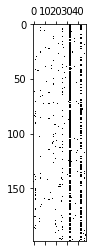

In [13]:
plt.spy(A_matrix.toarray())

In [14]:
import sys
!{sys.executable} -m pip install pysclump --user

In [15]:
from pysclump import PathSim
import numpy as np

type_lists = {'A': x_lab, 'C': y_lab}

incidence_matrices = {'AC': A_matrix.toarray()}

In [16]:
incidence_matrices['AC']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int8)

In [17]:
# Create PathSim instance.
ps = PathSim(type_lists, incidence_matrices)

In [18]:
df['Yelp ID'].head()

0    AlO78to1upUkVhRx12XtVA
1    7PGyWA51sSdw8M4fBXa9Gw
2    n3sKOKoEk_gKhBvgfIwZaA
3    4GT1sQ_pcKk4gBMrJddexw
4    PzGU5brzhsVqumdU4qE5Rw
Name: Yelp ID, dtype: object

In [19]:
# Get the similarity between two authors (indicated by type 'A').
ps.pathsim('AlO78to1upUkVhRx12XtVA', 'n3sKOKoEk_gKhBvgfIwZaA', metapath='ACA')

0.6666666666666666

In [20]:
# Now we have to see which restaurant
results = {}
for restaurant in df['Yelp ID']:
    results[restaurant] = ps.pathsim('AlO78to1upUkVhRx12XtVA', restaurant, metapath='ACA')
sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse = True)}

In [21]:
# Here we can see the similarity search results for the given metapath 'ACA'
# We will have better and more varying similarity results with other metapaths  

In [22]:
# Top N sorted_results
N = 50
out = dict(list(sorted_results.items())[0: N])
out

{'AlO78to1upUkVhRx12XtVA': 1.0,
 '7PGyWA51sSdw8M4fBXa9Gw': 1.0,
 'W0dzJ7E6R3kyAOXIlO_tbw': 1.0,
 'Bne55NwL25KO_ntMgflb_A': 1.0,
 '9QifYbaGw27jgDBhXjg1vQ': 1.0,
 'tAC_kv3MRcWW0CGfbJlXzA': 1.0,
 'UPqvlPxU_8lVrBGvqyzj9Q': 1.0,
 'Um1q8DykJrsXpNSbVIyeaQ': 1.0,
 'nI05KZBAKSuntpRnh0UOmA': 1.0,
 'Aq0sFUXE_q1yPCnOMPIxNA': 1.0,
 '80ZK_Udz9ifbHoWu_qTG7w': 1.0,
 'tptN11eE0AAjvZFN042Z0Q': 1.0,
 'QuEfLPcIAmNT85grJn20DA': 1.0,
 'ppjJpX3nsa1X_UKqvo109g': 1.0,
 'mRzFxj2hFoMSj4lwOM6ZaA': 1.0,
 'v9N_8HDGrOGoZ2_2EClqXA': 1.0,
 'g3yU8A2F1a-u7t8LqAesdA': 1.0,
 'C3gEbNEYvIKJfHAIUU2Fcg': 1.0,
 'aQJwib4ut3J93ZNrz6yX3w': 1.0,
 'K_6pzTkNzaNqSFHNKPHA4Q': 1.0,
 'lyjZGZvc4DfYjtvcYY6tAg': 1.0,
 'njmn7hPCbFeQEU5EOO8kGg': 1.0,
 'tzWX3qRpa09sIlvdSRnh2Q': 1.0,
 '_ljQWL4JtbGkqIR57HSgdA': 1.0,
 '6sxAvbRBxy1hymvoDb8spQ': 1.0,
 'L5BCo3Sy8UkodiEpva8G3Q': 1.0,
 'i46yuYrEGtryVbi3Az2YtA': 1.0,
 'u8cQgWxKM8xNcNxPHpjjyA': 1.0,
 '4XT5_w4iDOaU0UJHYzeJcA': 1.0,
 '_lhibkzOoJbE7_ISHZjSrg': 1.0,
 '5lZEJRCK-FDPrzkejxI4yg': 1.0,
 'pXKqmw

In [23]:
# Now display which restaurants were the most similar to the input restaurant by 
# returning a dataframe 
top_ten = list(sorted_results.keys())[:10]

In [24]:
df[['Name', 'URL', 'Rating', 'Review Count']][df['Yelp ID'].isin(top_ten)]

,Name,URL,Rating,Review Count
0,Cucina Basilico,https://www.yelp.com/biz/cucina-basilico-san-d...,4.5,574
1,Buon Appetito,https://www.yelp.com/biz/buon-appetito-san-die...,4.0,2291
8,Ristorante Illando,https://www.yelp.com/biz/ristorante-illando-sa...,4.5,974
9,Pomodoro Ristorante Italiano,https://www.yelp.com/biz/pomodoro-ristorante-i...,4.5,923
11,Salvatore's Cucina Italiana,https://www.yelp.com/biz/salvatores-cucina-ita...,4.5,765
15,Volare,https://www.yelp.com/biz/volare-san-diego?adju...,4.0,651
20,Arrivederci Ristorante,https://www.yelp.com/biz/arrivederci-ristorant...,4.0,1375
24,Piacere Mio - South Park,https://www.yelp.com/biz/piacere-mio-south-par...,4.5,1083
25,Devine Pastabilities,https://www.yelp.com/biz/devine-pastabilities-...,4.5,1565
28,Ciccia Osteria,https://www.yelp.com/biz/ciccia-osteria-san-di...,4.5,210
